In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

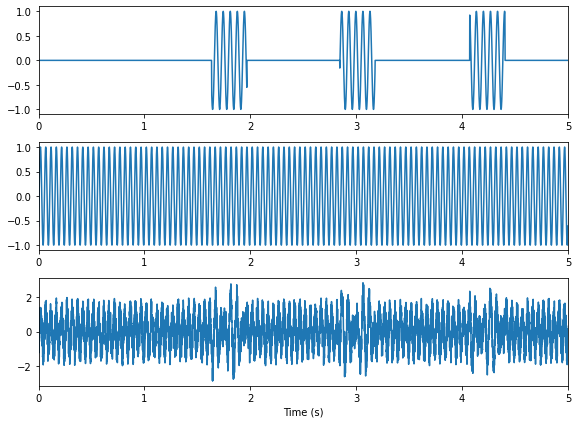

In [2]:
# Generate a simulated signal with 3, bursts at 15Hz with 5 cycles
# and an oscillation at 20Hz, plus white noise

# Time step (s)
dt=.001
# Duration (s)
T=5
# Time vector
time=np.linspace(0,T,int(T/dt))
# Sampling rate
srate=1/dt

# Burst frequency
f1 = 15
# Length of bursts in cycles
f1_num_cycles=5
# Number of bursts
f1_num_bursts=3

# Oscillation frequency
f2 = 20

# Burst signal
s1=np.zeros((len(time)))

# Keep track of burst start and stop times so they
# don't overlap
burst_starts=[]
burst_stops=[]
while len(burst_starts)<f1_num_bursts:
    # Burst duration in seconds
    dur_s=f1_num_cycles/f1
    # Burst duration in time steps
    dur_pts=int(dur_s/dt)
    
    # Random start and stop time
    start=np.random.randint(int(T/dt)-dur_pts)
    stop=start+dur_pts
    
    # Check that doesn't overlap with other bursts
    overlap=False
    for (other_start,other_stop) in zip(burst_starts,burst_stops):
        if (start >= other_start and start < other_stop) or (stop > other_start and stop <= other_stop):
            overlap=True
            break
          
    # Generate burst
    if not overlap:
        s1[start:stop]=np.sin(2. * np.pi * f1 * (time[start:stop]+np.random.randn()))
        burst_starts.append(start)
        burst_stops.append(stop)

# Oscillatory signal
s2=np.sin(2. * np.pi * f2 * (time+np.random.randn()))

# Generated signal
signal=s1+s2+np.random.uniform(-1,1,len(time))

plt.figure(figsize=(8,6))
plt.subplot(3,1,1)
plt.plot(time,s1)
plt.xlim(time[[0,-1]])
plt.subplot(3,1,2)
plt.plot(time,s2)
plt.xlim(time[[0,-1]])
plt.subplot(3,1,3)
plt.plot(time,signal)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.tight_layout()

In [17]:
import scipy.io
from scipy.io import loadmat
d=loadmat('signal.mat')
signal=np.squeeze(d['signal'])

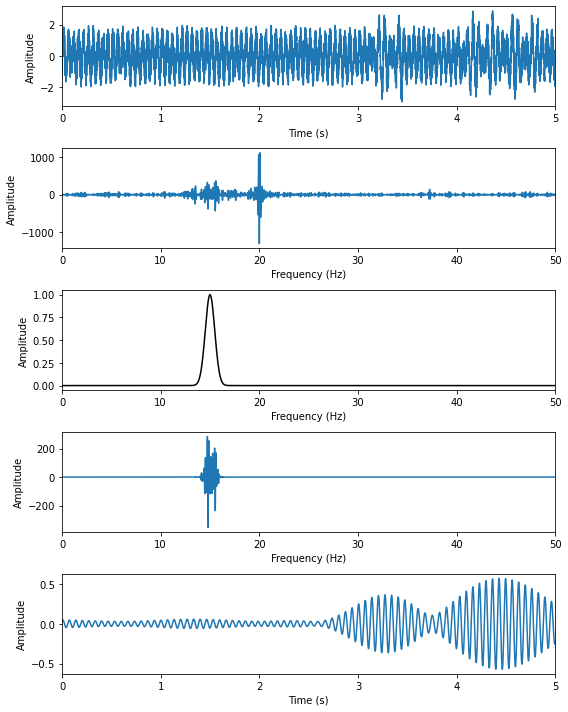

In [18]:
# Bandpass filtering using multiplication by a Gaussian kernel
# in the frequency domain

# Frequencies to evaluate (just to compute desired frequency
# resolution in this step)
freqs=np.linspace(5,100,100)

# Determine the frequency resolution
df = np.diff(freqs)[0]

# Zero-pad the signal - or is mean-pad better?
pad=np.zeros((len(time)))
padd_signal = np.hstack([pad, signal, pad])

# Fourier transform the padded signal
signal_fft = np.fft.rfft(padd_signal, axis=-1)    
fft_frex = np.fft.rfftfreq(padd_signal.shape[-1], d=1/srate)

# Kernel width for multiplication
sigma = df * .5

# Center pass-band frequency
freq=15

# Gaussian kernel centered on frequency with width defined
# by requested frequency resolution
kernel = np.exp(-((fft_frex - freq) ** 2 / (2.0 * sigma ** 2)))

# Multiply Fourier-transformed signal by kernel
fsignal_fft = np.multiply(signal_fft, kernel)
# Reverse Fourier to get bandpass filtered signal
f_signal = np.fft.irfft(fsignal_fft, axis=-1)

plt.figure(figsize=(8,10))
plt.subplot(5,1,1)
plt.plot(time,signal)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(5,1,2)
plt.plot(fft_frex,signal_fft)
plt.xlim([0,50])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,3)
plt.plot(fft_frex,kernel,'k')
plt.xlim([0,50])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,4)
plt.plot(fft_frex,fsignal_fft)
plt.xlim([0,50])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(5,1,5)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()

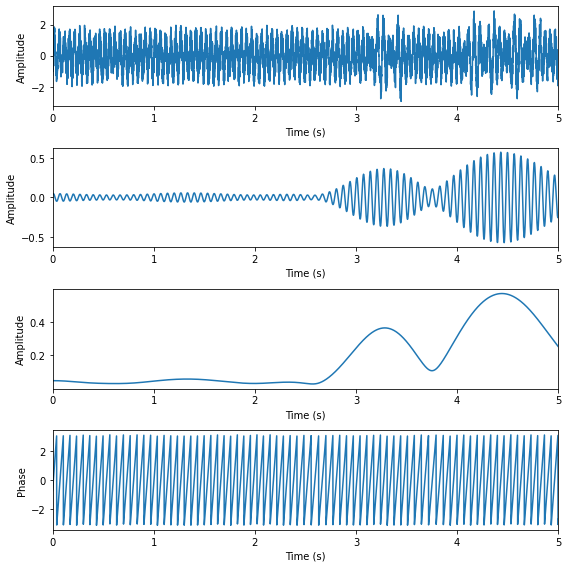

In [19]:
# Get analytic signal of bandpass filtered data (phase and amplitude)
analytic_signal = hilbert(f_signal, N=None, axis=-1)
# Cut off padding
analytic_signal=analytic_signal[len(time):2 * len(time)]

plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(time,signal)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,2)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,3)
plt.plot(time,np.abs(analytic_signal))
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,4)
plt.plot(time,np.angle(analytic_signal))
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Phase')


plt.tight_layout()

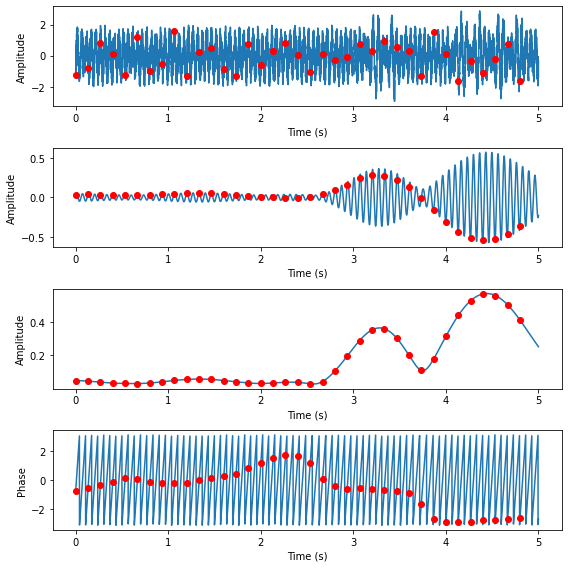

In [20]:
# Evaluate lagged coherence at a lag of 2 cycles
lag=2

# Duration of this lag in s
lag_dur_s = lag / freq
# Number of evaluations
n_evals = int(np.floor(T / lag_dur_s))
# Remaining time
diff = T - (n_evals * lag_dur_s)

# Start time
start_time = time[0]
# Evaluation times (ms)
eval_times = np.linspace(start_time, T - diff, n_evals + 1)[:-1]
# Evaluation time points
eval_pts = np.searchsorted(time, eval_times)


plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(time,signal)
plt.plot(eval_times,signal[eval_pts],'ro')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,2)
plt.plot(time,f_signal[len(time):2 * len(time)])
plt.plot(eval_times,f_signal[len(time)+eval_pts],'ro')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,3)
plt.plot(time,np.abs(analytic_signal))
plt.plot(eval_times,np.abs(analytic_signal[eval_pts]),'ro')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,4)
plt.plot(time,np.angle(analytic_signal))
plt.plot(eval_times,np.angle(analytic_signal[eval_pts]),'ro')
plt.xlabel('Time (s)')
plt.ylabel('Phase')

plt.tight_layout()

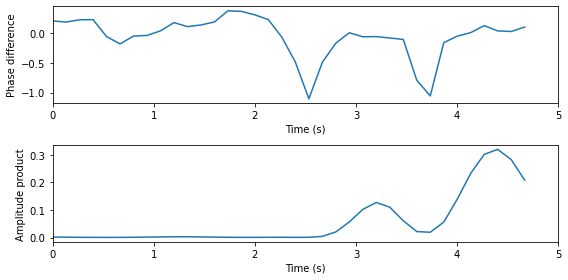

In [21]:
# Analytic signal at n=0...n_evals-1 evaluation points
f1 = analytic_signal[eval_pts[:-1]]
# Analytic signal at n=1...n_evals evaluation points
f2 = analytic_signal[eval_pts[1:]]
# calculate the phase difference and amplitude product
phase_diff = np.angle(f2) - np.angle(f1)
amp_prod=np.abs(f1) * np.abs(f2)

plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(eval_times[:-1],phase_diff)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Phase difference')

plt.subplot(2,1,2)
plt.plot(eval_times[:-1],amp_prod)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude product')

plt.tight_layout()


In [22]:
# Numerator - sum is over evaluation points
num = np.abs(np.sum(amp_prod * np.exp(complex(0, 1) * phase_diff), axis=-1))
print(num)

2.074870008170694


In [23]:
# Scaling factor - sum is over evaluation points
f1_pow = np.power(f1, 2)
f2_pow = np.power(f2, 2)
denom = np.sqrt(np.sum(np.abs(f1_pow), axis=-1) * np.sum(np.abs(f2_pow), axis=-1))
print(denom)

2.1520289319485664


In [24]:
lc = num / denom
print(lc)

0.9641459635451981


In [25]:
# This was evaluated starting at time t=0 and looking 2 cycles ahead, 
# but what about the points in between?

# Number of points between the first and next evaluation time points
n_range = eval_pts[1] - eval_pts[0]
# Analytic signal at n=0...n_evals-1 evaluation points, and m=0..n_range time points in between
f1 = analytic_signal[eval_pts[:-1,np.newaxis] + np.arange(n_range)][:, np.newaxis]
# Analytic signal at n=1...n_evals evaluation points, and m=0..n_range time points in between
f2 = analytic_signal[eval_pts[1:,np.newaxis] + np.arange(n_range)][:, np.newaxis]

# Calculate the phase difference and amplitude product
phase_diff = np.angle(f2) - np.angle(f1)
amp_prod = np.abs(f1) * np.abs(f2)

# Lagged coherence
num = np.abs(np.sum(amp_prod * np.exp(complex(0, 1) * phase_diff),axis=0))
f1_pow = np.power(f1, 2)
f2_pow = np.power(f2, 2)
denom = np.sqrt(np.sum(np.abs(f1_pow),axis=0) * np.sum(np.abs(f2_pow),axis=0))
lc = num / denom

# Average over the time points in between evaluation points
lc = np.mean(lc)
print(lc)

0.9637074584914355


In [26]:
# Putting it all together

def lagged_hilbert_coherence(signal, srate, freq, lag):
    """
    Calculate the lagged Hilbert coherence at a given frequency and lag of a signal.

    Args:
    signal (numpy.ndarray): The signal to analyze.
    srate (int): The sampling rate of the signal.
    freq (int): The frequency to compute coherence at
    lag (int): The time lag in cycles to calculate the coherence

    Returns:
    tuple: A tuple containing three numpy.ndarray objects: num, denom, and lc.
    num is the numerator of the lagged coherence calculation,
    denom is the denominator, and
    lc is the lagged Hilbert coherence at the given frequency and lag.
    """

    n_pts = len(signal)
    T = n_pts * 1 / srate
    time = np.linspace(0, T, int(T * srate))
    
    # Bandpass filtering using multiplication by a Gaussian kernel
    # in the frequency domain

    # Frequencies to evaluate (just to compute desired frequency
    # resolution in this step)
    freqs=np.linspace(5,100,100)

    # Determine the frequency resolution
    df = np.diff(freqs)[0]

    # Zero-pad the signal - or is mean-pad better?
    pad=np.zeros((len(signal)))
    padd_signal = np.hstack([pad, signal, pad])

    # Fourier transform the padded signal
    signal_fft = np.fft.rfft(padd_signal, axis=-1)    
    fft_frex = np.fft.rfftfreq(padd_signal.shape[-1], d=1/srate)

    # Kernel width for multiplication
    sigma = df * .5

    # Gaussian kernel centered on frequency with width defined
    # by requested frequency resolution
    kernel = np.exp(-((fft_frex - freq) ** 2 / (2.0 * sigma ** 2)))

    # Multiply Fourier-transformed signal by kernel
    fsignal_fft = np.multiply(signal_fft, kernel)
    # Reverse Fourier to get bandpass filtered signal
    f_signal = np.fft.irfft(fsignal_fft, axis=-1)
    
    # Get analytic signal of bandpass filtered data (phase and amplitude)
    analytic_signal = hilbert(f_signal, N=None, axis=-1)
    # Cut off padding
    analytic_signal=analytic_signal[len(time):2 * len(time)]
    
    # Duration of this lag in s
    lag_dur_s = lag / freq
    # Number of evaluations
    n_evals = int(np.floor(T / lag_dur_s))
    # Remaining time
    diff = T - (n_evals * lag_dur_s)

    # Start time
    start_time = time[0]
    # Evaluation times (ms)
    eval_times = np.linspace(start_time, T - diff, n_evals + 1)[:-1]
    # Evaluation time points
    eval_pts = np.searchsorted(time, eval_times)
    
    # This was evaluated starting at time t=0 and looking 2 cycles ahead, 
    # but what about the points in between?

    # Number of points between the first and next evaluation time points
    n_range = eval_pts[1] - eval_pts[0]
    # Analytic signal at n=0...n_evals-1 evaluation points, and m=0..n_range time points in between
    f1 = analytic_signal[eval_pts[:-1,np.newaxis] + np.arange(n_range)][:, np.newaxis]
    # Analytic signal at n=1...n_evals evaluation points, and m=0..n_range time points in between
    f2 = analytic_signal[eval_pts[1:,np.newaxis] + np.arange(n_range)][:, np.newaxis]

    # Calculate the phase difference and amplitude product
    phase_diff = np.angle(f2) - np.angle(f1)
    amp_prod = np.abs(f1) * np.abs(f2)

    # Lagged coherence
    num = np.abs(np.sum(amp_prod * np.exp(complex(0, 1) * phase_diff),axis=0))
    f1_pow = np.power(f1, 2)
    f2_pow = np.power(f2, 2)
    denom = np.sqrt(np.sum(np.abs(f1_pow),axis=0) * np.sum(np.abs(f2_pow),axis=0))
    lc = num / denom

    # Average over the time points in between evaluation points
    lc = np.mean(lc)

    return num, denom, lc

Text(0, 0.5, 'Lagged coherence')

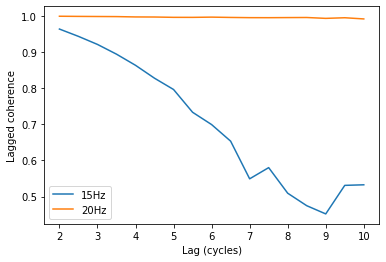

In [36]:
# Evaluate at 2-10 lag cycles
lags=np.arange(2,10.5,.5)
# Evaluate at 15 and 20 Hz
freqs=[15, 20]

for f_idx,freq in enumerate(freqs):
    lcs=np.zeros(len(lags))
    for l_idx,lag in enumerate(lags):
        num, denom, lcs[l_idx] = lagged_hilbert_coherence(signal, srate, freq, lag)

    plt.plot(lags,lcs,label='{}Hz'.format(freq))
plt.legend()
plt.xlabel('Lag (cycles)')
plt.ylabel('Lagged coherence')

In [28]:
# What about at a frequency where we know there is only noise?
num, denom, lc = lagged_hilbert_coherence(signal, srate, 40, 5)
print(lc)

0.9402460115010302


In [29]:
# What's going on?
num1, denom1, lc1 = lagged_hilbert_coherence(signal, srate, 15, 5)
num2, denom2, lc2 = lagged_hilbert_coherence(signal, srate, 40, 5)

print('15Hz: numerator={}, denominator={}, lc={}'.format(np.mean(num1), np.mean(denom1), lc1))
print('40Hz: numerator={}, denominator={}, lc={}'.format(np.mean(num2), np.mean(denom2), lc2))

15Hz: numerator=0.6772055684437892, denominator=0.850679324429039, lc=0.7963531719263741
40Hz: numerator=0.025036536746766563, denominator=0.02662736607548933, lc=0.9402460115010302


Text(0, 0.5, 'Frequency (Hz)')

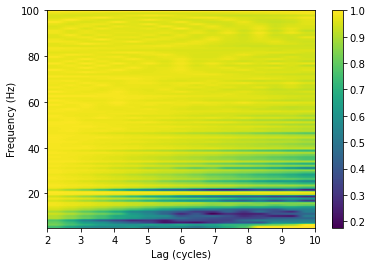

In [38]:
# At 40Hz, the numerator and denominator are both low, but nearly exactly the same
# I think this is due to amplitude correlations introduced by bandpass filtering in a freq
# range with low power (https://journals.physiology.org/doi/full/10.1152/jn.00851.2013)
# Here's the effect over a range of frequencies

# Evaluate at 2-10 lag cycles
lags=np.arange(2,10.5,.5)
# Evaluate at 5-100 Hz
freqs=np.linspace(5,100,100)

lcs=np.zeros((len(freqs),len(lags)))
for f_idx,freq in enumerate(freqs):    
    for l_idx,lag in enumerate(lags):
        num, denom, lcs[f_idx,l_idx] = lagged_hilbert_coherence(signal, srate, freq, lag)
        
im=plt.imshow(lcs, extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto')
plt.colorbar(im)
plt.xlabel('Lag (cycles)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

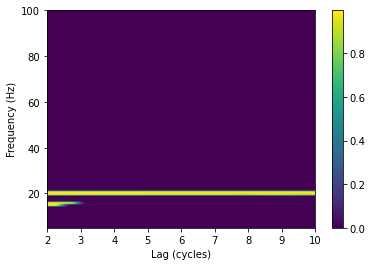

In [39]:
# The solution I found is to temporally shuffle the signal a bunch
# of times and use the distribution of broadband
# amplitude products as a threshold on the denominator. 
# Temporal shuffling may not be the best surrogate method though

def temporal_shuffle(signal):
    """
    Shuffle a given signal and return the mean of
    the product of the absolute amplitude of the analytic signal
    at adjacent time points

    Args:
    signal (numpy.ndarray): The signal to be shuffled.
    
    Returns:
    float: Mean of the product of the absolute amplitude of the
    analytic signal at adjacent time points.
    """
    n_pts=len(signal)
    rand_signal = signal[np.random.permutation(n_pts)]
    pad = np.zeros(n_pts)
    padd_rand_signal = np.hstack([pad, rand_signal, pad])
    # Get analytic signal (phase and amplitude)
    analytic_rand_signal = hilbert(padd_rand_signal, N=None)[n_pts:2 * n_pts]

    # Analytic signal at n=0...-1
    f1 = analytic_rand_signal[0:-1]
    # Analytic signal at n=1,...
    f2 = analytic_rand_signal[1:]

    amp_prod = np.abs(f1) * np.abs(f2)
    return np.mean(amp_prod[:])

# Compute threshold as 5th percentile of shuffled amplitude
# producs
n_shuffles=100
amp_prods=np.zeros(n_shuffles)
for i in range(n_shuffles):
    amp_prods[i]=temporal_shuffle(signal)
threshold=np.percentile(amp_prods,5)

# Evaluate at 2-10 lag cycles
lags=np.arange(2,10.5,.5)
# Evaluate at 5-100 Hz
freqs=np.linspace(5,100,100)

lcs=np.zeros((len(freqs),len(lags)))
for f_idx,freq in enumerate(freqs):    
    for l_idx,lag in enumerate(lags):
        num, denom, lc = lagged_hilbert_coherence(signal, srate, freq, lag)
        # Only consider lc if denominator greater than threshold
        if np.mean(denom)>=threshold:
            lcs[f_idx,l_idx]=lc
        
im=plt.imshow(lcs, extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto')
plt.colorbar(im)
plt.xlabel('Lag (cycles)')
plt.ylabel('Frequency (Hz)')

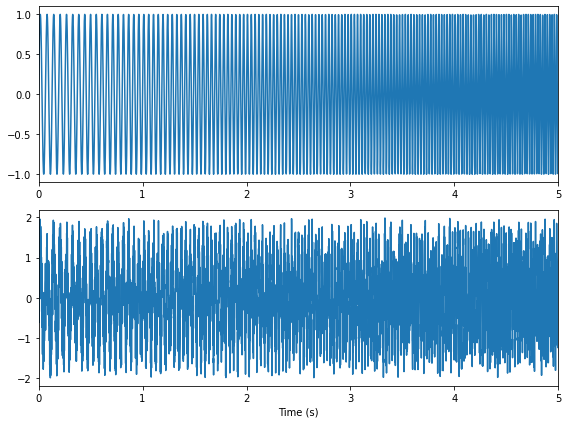

In [47]:
# Let's see what happens when the frequency of a signal changes over time
# Generate a simulated signal that starts as a 15Hz oscillation and 
# increases to 30Hz, plus white noise

# Time step (s)
dt=.001
# Duration (s)
T=5
# Time vector
time=np.linspace(0,T,int(T/dt))
# Sampling rate
srate=1/dt

f0 = 15         # Initial frequency
f1 = 30        # Final frequency
k = (f1-f0)/1   # Rate of change of frequency

# Burst signal
s1=np.sin(2. * np.pi * (f0+(f1-f0)*(time/np.max(time)))*time)



# Generated signal
signal=s1+np.random.uniform(-1,1,len(time))

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(time,s1)
plt.xlim(time[[0,-1]])
plt.subplot(2,1,2)
plt.plot(time,signal)
plt.xlim(time[[0,-1]])
plt.xlabel('Time (s)')
plt.tight_layout()


Text(0, 0.5, 'Frequency (Hz)')

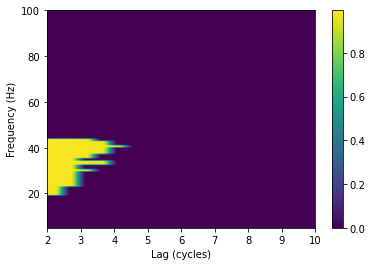

In [48]:
# Compute threshold as 5th percentile of shuffled amplitude
# producs
n_shuffles=100
amp_prods=np.zeros(n_shuffles)
for i in range(n_shuffles):
    amp_prods[i]=temporal_shuffle(signal)
threshold=np.percentile(amp_prods,5)

# Evaluate at 2-10 lag cycles
lags=np.arange(2,10.5,.5)
# Evaluate at 5-100 Hz
freqs=np.linspace(5,100,100)

lcs=np.zeros((len(freqs),len(lags)))
for f_idx,freq in enumerate(freqs):    
    for l_idx,lag in enumerate(lags):
        num, denom, lc = lagged_hilbert_coherence(signal, srate, freq, lag)
        # Only consider lc if denominator greater than threshold
        if np.mean(denom)>=threshold:
            lcs[f_idx,l_idx]=lc
        
im=plt.imshow(lcs, extent=[lags[0], lags[-1], freqs[0], freqs[-1]], origin='lower', aspect='auto')
plt.colorbar(im)
plt.xlabel('Lag (cycles)')
plt.ylabel('Frequency (Hz)')